# Degree group EDA

https://github.com/greenelab/connectivity-search-analyses/issues/176

In [1]:
import pandas as pd
import numpy as np
import plotnine as pn

from hetmatpy.hetmat import HetMat
from hetmatpy.degree_weight import dwpc
from hetmatpy.degree_group import dwpc_to_degrees
from hetmatpy.pipeline import add_gamma_hurdle_to_dgp_df

import sys
sys.path.append("..")
from src.database_utils import get_db_connection

In [2]:
# path = "../data/hetionet-v1.0.hetmat"
# use HetMat from local connectivity-search-backend which has downloaded all path counts
path = "../../connectivity-search-backend/dj_hetmech_app/management/commands/downloads/hetionet-v1.0.hetmat"
hm = HetMat(path)
hm

In [3]:
metapath = hm.metagraph.get_metapath("CbGpPWpG")
metapath

CbGpPWpG

In [4]:
# %%time
# row_ids, col_ids, dwpc_matrix = dwpc(hm, metapath, damping=0.5)
# dwpc_matrix

In [5]:
row_ids, col_ids, pc_matrix = hm.read_path_counts(metapath = metapath, metric="dwpc", damping=0.0)
row_ids, col_ids, dwpc_matrix = hm.read_path_counts(metapath = metapath, metric="dwpc", damping=0.5)

In [6]:
# density
pc_matrix.nnz / (len(row_ids) * len(col_ids))

0.13639481041411847

In [7]:
path = hm.get_running_degree_group_path(metapath, metric="dwpc", damping=0.5)
degree_group_null_df = pd.read_table(path)
degree_group_null_df["metapath"] = str(metapath)
# rename columns. See https://github.com/greenelab/connectivity-search-backend/blob/28d9626d75c5fa78b03ae0cb18b32f90bcf1fe8f/dj_hetmech_app/management/commands/populate_database.py#L254-L259
renamer = {
    "n": "n_dwpcs",  # n_null_dwpcs
    "nnz": "n_nonzero_dwpcs",  # n_null_dwpcs_nonzero
    "mean_nz": "nonzero_dwpc_mean",  # null_dwpc_nonzero_mean
    "sd_nz": "nonzero_dwpc_sd",  # null_dwpc_nonzero_sd
    "beta": "dwpc_beta",  # null_dwpc_beta
    "alpha": "dwpc_alpha",  # null_dwpc_alpha
}
degree_group_null_df = (
    degree_group_null_df
    .pipe(add_gamma_hurdle_to_dgp_df)
    .rename(columns=renamer)
    .eval("dwpc_density = n_nonzero_dwpcs / n_dwpcs")
    .eval("dwpc_mean = (nonzero_dwpc_mean * n_nonzero_dwpcs) / n_dwpcs")
    .eval("n_dwpcs_mean = n_dwpcs / n_perms")
    .eval("n_nonzero_dwpcs_mean = n_nonzero_dwpcs / n_perms")
    .drop(columns=["sum", "sum_of_squares", "n_dwpcs", "n_nonzero_dwpcs"])
    .fillna({"dwpc_mean": 0.0})
    .assign(metric_type="permuted")
)
degree_group_null_df.head(2)

,source_degree,target_degree,n_perms,metapath,nonzero_dwpc_mean,nonzero_dwpc_sd,dwpc_beta,dwpc_alpha,dwpc_density,dwpc_mean,n_dwpcs_mean,n_nonzero_dwpcs_mean,metric_type
0,0,0,200,CbGpPWpG,NaN,None,NaN,NaN,0.0,0.0,1950458.0,0.0,permuted
1,0,1,200,CbGpPWpG,NaN,None,NaN,NaN,0.0,0.0,175551.0,0.0,permuted


In [8]:
%%time
rows = dwpc_to_degrees(hm, metapath)
dwpc_df = pd.DataFrame(rows)
dwpc_df.head()

CPU times: user 3min 6s, sys: 16.7 s, total: 3min 23s
Wall time: 3min 22s


,source_id,target_id,source_name,target_name,source_degree,target_degree,path_count,dwpc
0,DB00014,1,Goserelin,A1BG,2,0,0,0.000000
1,DB00014,2,Goserelin,A2M,2,16,2,0.975207
2,DB00014,9,Goserelin,NAT1,2,4,0,0.000000
3,DB00014,10,Goserelin,NAT2,2,6,0,0.000000
4,DB00014,12,Goserelin,SERPINA3,2,3,0,0.000000


In [9]:
%%time
def summarize(df: pd.DataFrame):
    nonzero_df = df.query("path_count > 0")
    return pd.Series({
        "n_dwpcs_mean": len(df),
        "n_nonzero_dwpcs_mean": len(nonzero_df),
        "dwpc_mean": df.dwpc.mean(),
        "nonzero_dwpc_mean": nonzero_df.dwpc.mean(),
        "nonzero_dwpc_sd": nonzero_df.dwpc.std(),
        "pc_mean": df.path_count.mean(),
        "dwpc_density": (df.path_count > 0).mean(),
    })

degree_group_orig_df = (
    dwpc_df
    .groupby(["source_degree", "target_degree"])
    .apply(summarize)
    .reset_index()
    .assign(metric_type="unpermuted")
    .assign(metapath=str(metapath))
)
degree_group_orig_df.head(3)

CPU times: user 14.9 s, sys: 680 ms, total: 15.5 s
Wall time: 15.5 s


,source_degree,target_degree,n_dwpcs_mean,n_nonzero_dwpcs_mean,dwpc_mean,nonzero_dwpc_mean,nonzero_dwpc_sd,pc_mean,dwpc_density,metric_type,metapath
0,0,0,1950458.0,0.0,0.0,NaN,NaN,0.0,0.0,unpermuted,CbGpPWpG
1,0,1,175551.0,0.0,0.0,NaN,NaN,0.0,0.0,unpermuted,CbGpPWpG
2,0,2,160718.0,0.0,0.0,NaN,NaN,0.0,0.0,unpermuted,CbGpPWpG


In [10]:
degree_group_df = pd.concat([
    degree_group_orig_df,
    degree_group_null_df,
], axis="rows").sort_values(["source_degree", "target_degree", "metric_type"])
degree_group_df.tail()

,source_degree,target_degree,n_dwpcs_mean,n_nonzero_dwpcs_mean,dwpc_mean,nonzero_dwpc_mean,nonzero_dwpc_sd,pc_mean,dwpc_density,metric_type,metapath,n_perms,dwpc_beta,dwpc_alpha
6117,132,192,1.0,1.0,5.024278,5.024278,NaN,457.0,1.0,unpermuted,CbGpPWpG,NaN,NaN,NaN
6118,132,204,1.0,1.0,4.981281,4.981281,0.143650,NaN,1.0,permuted,CbGpPWpG,200.0,241.396158,1202.462208
6118,132,204,1.0,1.0,6.325231,6.325231,NaN,1084.0,1.0,unpermuted,CbGpPWpG,NaN,NaN,NaN
6119,132,231,1.0,1.0,5.022980,5.022980,0.140275,NaN,1.0,permuted,CbGpPWpG,200.0,255.271186,1282.221998
6119,132,231,1.0,1.0,6.494795,6.494795,NaN,1191.0,1.0,unpermuted,CbGpPWpG,NaN,NaN,NaN


In [11]:
degree_group_df.to_csv("degree-group-analyses.tsv", sep="\t", index=False, float_format="%.5g")

In [12]:
degree_group_df = pd.read_table("degree-group-analyses.tsv")
len(degree_group_df)

12240

In [13]:
degree_group_melt_df = degree_group_df.melt(id_vars=["metapath", "source_degree", "target_degree", "metric_type"])
degree_group_melt_df.head()

,metapath,source_degree,target_degree,metric_type,variable,value
0,CbGpPWpG,0,0,permuted,n_dwpcs_mean,1950500.0
1,CbGpPWpG,0,0,unpermuted,n_dwpcs_mean,1950500.0
2,CbGpPWpG,0,1,permuted,n_dwpcs_mean,175550.0
3,CbGpPWpG,0,1,unpermuted,n_dwpcs_mean,175550.0
4,CbGpPWpG,0,2,permuted,n_dwpcs_mean,160720.0


In [14]:
target_degree_max = 40
source_degree_max = 20

def summarize(df):
    range_df = df.query("source_degree <= @source_degree_max and target_degree <= @target_degree_max")
    return pd.Series({
        "min_value": min(df.value.dropna()),
        "max_value": max(df.value.dropna()),
        "min_value_in_range": min(range_df.value.dropna()),
        "max_value_in_range": max(range_df.value.dropna()),
    })

range_df = degree_group_melt_df.groupby(["metapath", "variable"]).apply(summarize).reset_index()
range_df

,metapath,variable,min_value,max_value,min_value_in_range,max_value_in_range
0,CbGpPWpG,dwpc_alpha,0.978883,1.350651e+03,0.978883,2.252272e+01
1,CbGpPWpG,dwpc_beta,0.999462,2.781464e+02,0.999462,8.011930e+00
2,CbGpPWpG,dwpc_density,0.000000,1.000000e+00,0.000000,1.000000e+00
3,CbGpPWpG,dwpc_mean,0.000000,6.607900e+00,0.000000,2.822000e+00
4,CbGpPWpG,n_dwpcs_mean,1.000000,2.046200e+06,70.000000,2.046200e+06
5,CbGpPWpG,n_nonzero_dwpcs_mean,0.000000,8.138900e+04,0.000000,8.138900e+04
6,CbGpPWpG,n_perms,200.000000,2.000000e+02,200.000000,2.000000e+02
7,CbGpPWpG,nonzero_dwpc_mean,0.035931,6.607900e+00,0.786520,3.252600e+00
8,CbGpPWpG,nonzero_dwpc_sd,0.000000,3.209008e+00,0.592301,1.659257e+00
9,CbGpPWpG,pc_mean,0.000000,1.191000e+03,0.000000,2.010700e+01


In [15]:
variable_labels = {
    # 'n_dwpcs_mean',
    'n_nonzero_dwpcs_mean': "# Nonzero DWPCs",
    'dwpc_density': "% Nonzero DWPCs",
    'dwpc_mean': "Mean DWPC",
    'nonzero_dwpc_mean': "Nean Nonzero DWPC",
    'nonzero_dwpc_sd': "Std Dev Nonzero DWPC",
    # 'pc_mean': "Mean Path Count",
    # 'n_perms',
    'dwpc_beta': "Gamma Model β",
    # 'dwpc_alpha': "Gamma Model α",
}
metric_type_labels = {
    "unpermuted": "Unpermuted Hetnet",
    "permuted": "Permuted Hetnets (Null)",
}
labeller = pn.labeller(rows=variable_labels, cols=metric_type_labels)


In [16]:
plot_df = (
    degree_group_melt_df
    .query("variable in @variable_labels")
    .query("source_degree <= @source_degree_max and target_degree <= @target_degree_max")
    .merge(range_df[["metapath", "variable", "max_value_in_range"]])
    .eval("value_scaled = value / max_value_in_range")
)
plot_df['metric_type'] = plot_df['metric_type'].astype('category').cat.reorder_categories(["unpermuted", "permuted"])
plot_df['variable'] = plot_df['variable'].astype('category').cat.reorder_categories(list(variable_labels))

In [17]:
# https://github.com/dhimmel/hetior/blob/master/R/plotting.R
theme_dhimmel = pn.theme(
    # background of facet labels (element_rect; inherits from rect)
    strip_background = pn.element_rect(fill = '#fef2e2', colour = '#7f7f7f', size = 0.2),
    # margin around entire plot (unit with the sizes of the top, right, bottom, and left margins)
    # plot_margin = pn.margin(t=2, r=2, b=2, l=2),
    # extra space added around legend (unit)
    # legend_spacing = pn.unit(0.1, 'cm'),
    # background underneath legend keys (element_rect; inherits from rect)
)


/home/dhimmel/miniconda3/envs/hetmech/lib/python3.8/site-packages/plotnine/facets/facet_grid.py:136: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/home/dhimmel/miniconda3/envs/hetmech/lib/python3.8/site-packages/plotnine/facets/facet_grid.py:137: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead


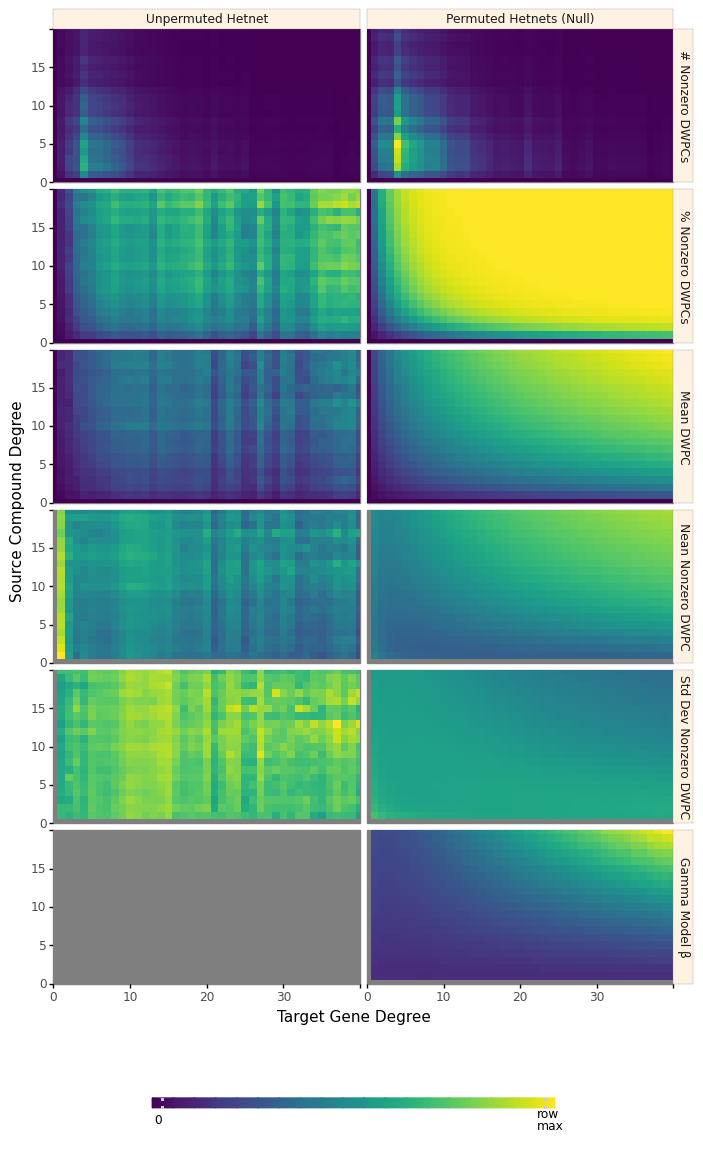

<ggplot: (8751266590606)>

In [18]:
plot_vars = ["dwpc_mean", "nonzero_dwpc_mean", "nonzero_dwpc_sd"]
figure = (
    pn.ggplot(plot_df, pn.aes(x='target_degree', y='source_degree', fill="value_scaled"))
    + pn.geom_tile(na_rm=True)
    + pn.facet_grid("variable ~ metric_type", labeller=labeller)
    + pn.scale_x_continuous(expand=(0, 0), labels=["0", "10", "20", "30", None]) 
    + pn.scale_y_continuous(expand=(0, 0), labels=["0", "5", "10", "15", None])
    + pn.labs(x=f"Target {metapath.target()} Degree", y=f"Source {metapath.source()} Degree")
    + pn.scale_fill_continuous(breaks=(0, 1), guide=pn.guide_colorbar(barwidth = 5, barheight=40), labels=["0", "row\nmax"])
    + pn.theme_bw()
    + theme_dhimmel
    + pn.theme(
        legend_key = pn.element_blank(),
        legend_position=(.5, 0.002),
        legend_direction='horizontal',
        legend_title=pn.element_blank(),
        # legend_margin=,
        figure_size=(8, 4)
    )
    + pn.coord_fixed(xlim=(0, target_degree_max), ylim=(0, source_degree_max), ratio=1)
)
figure

In [19]:
pn.ggsave(figure, "degree-group-analyses.png", dpi=600)
# pn.ggsave(figure, "degree-group-analyses.svg")
pn.ggsave(figure, "degree-group-analyses.pdf")

/home/dhimmel/miniconda3/envs/hetmech/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 8 x 4 in image.
/home/dhimmel/miniconda3/envs/hetmech/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: degree-group-analyses.png
/home/dhimmel/miniconda3/envs/hetmech/lib/python3.8/site-packages/plotnine/facets/facet_grid.py:136: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/home/dhimmel/miniconda3/envs/hetmech/lib/python3.8/site-packages/plotnine/facets/facet_grid.py:137: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/home/dhimmel/miniconda3/envs/hetmech/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 8 x 4 in image.
/home/dhimmel/miniconda3/en